# COMP90086 Project

In [157]:
import cv2
from matplotlib import pyplot as plt
import numpy as np
import copy
import glob
import os, sys
import time
from tqdm import tqdm
from scipy.ndimage import uniform_filter, gaussian_filter

import warnings
warnings.filterwarnings("ignore")

## Prepare dataset

In [2]:
rootpath='./Dataset'
img_path = rootpath + '/'
disparity_imgs = glob.glob(img_path +'*.png')
left_right_imgs = glob.glob(img_path +'*.jpg')

for i in range(len(disparity_imgs)):
    disparity_imgs[i] = disparity_imgs[i][10:]
disparity_imgs = sorted(disparity_imgs)

for i in range(len(left_right_imgs)):
    left_right_imgs[i] = left_right_imgs[i][10:]
left_right_imgs = np.array(sorted(left_right_imgs)).reshape(25,2)
    
print("Example disparity image:\n", disparity_imgs[0])
print("Example pair of left and right images:\n", left_right_imgs[0])

Example disparity image:
 2018-07-09-16-11-56_2018-07-09-16-11-56-702-disparity.png
Example pair of left and right images:
 ['2018-07-09-16-11-56_2018-07-09-16-11-56-702-left.jpg'
 '2018-07-09-16-11-56_2018-07-09-16-11-56-702-right.jpg']


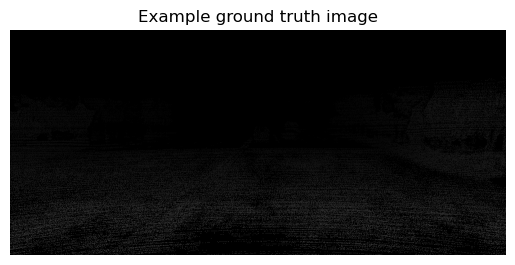

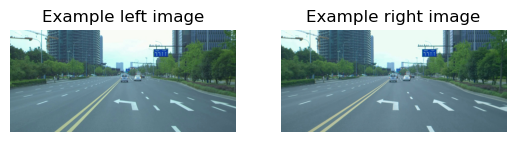

In [3]:
img_gt = cv2.imread(os.path.join(rootpath, disparity_imgs[0]))
img_left = cv2.imread(os.path.join(rootpath, left_right_imgs[0][0]))
img_right = cv2.imread(os.path.join(rootpath, left_right_imgs[0][1]))

plt.imshow(img_gt)
plt.title('Example ground truth image')
plt.axis('off')
plt.show()

plt.subplot(2, 2, 1)
plt.imshow(img_left[:,:,::-1])
plt.title('Example left image')
plt.axis('off')

plt.subplot(2, 2, 2)
plt.imshow(img_right[:,:,::-1])
plt.title('Example right image')
plt.axis('off')
plt.show()


## Matching functions

### Basic matching functions (SSD & NCC)

In [45]:
def ssd(im_l, im_r, steps, window_size):
    height, width = im_l.shape
    s = np.zeros((height, width))
    dmaps = np.zeros((height, width,steps))
    
    # try different disparity
    for displ in range(steps):
        # make the left image move
        move_l = np.roll(im_l, - displ, axis=1)
        
        # calculate the sum of the square difference
        uniform_filter((move_l - im_r) ** 2, window_size, s)
        
        # save the ssd score
        dmaps[:,:,displ] = s
        
    return np.argmin(dmaps, axis=2)

def ncc(im_l,im_r, steps, window_size):
    height, width = im_l.shape
    
    mean_l = np.zeros((height, width))
    mean_r = np.zeros((height, width))
    s = np.zeros((height, width))
    s_l = np.zeros((height, width))
    s_r = np.zeros((height, width))
    
    dmaps = np.zeros((height, width,steps))
    
    # calculate the mean of the image block
    uniform_filter(im_l,window_size,mean_l)
    uniform_filter(im_r,window_size,mean_r)
    
    # try different disparity
    for displ in range(steps):
        # make the left image move
        move_l = np.roll(im_l, - displ, axis=1)

        uniform_filter(move_l * im_r, window_size, s)
        uniform_filter(move_l * move_l, window_size, s_l)
        uniform_filter(im_r * im_r, window_size,s_r)
        
        dmaps[:,:,displ] = s / np.sqrt(s_l * s_r)
        
    return np.argmax(dmaps, axis=2)


### Other matching functions (ZSSD & ZNCC)

In [111]:
def zssd(im_l, im_r, steps, window_size):
    height, width = im_l.shape
    
    mean_l = np.zeros((height, width))
    mean_r = np.zeros((height, width))
    s = np.zeros((height, width))
    
    dmaps = np.zeros((height, width,steps))
    
    # calculate the mean of the image block
    uniform_filter(im_l,window_size,mean_l)
    uniform_filter(im_r,window_size,mean_r)
    
    # try different disparity
    for displ in range(steps):
        # make the left image move to the right
        move_l = np.roll(im_l, - displ, axis=1)
        
        # calculate the sum of the square difference
        uniform_filter((im_r - mean_r - move_l + mean_l) ** 2, window_size, s)
        
        dmaps[:,:,displ] = s
        
    return np.argmin(dmaps, axis=2)

def zncc(im_l,im_r, steps, window_size):
    height, width = im_l.shape
    
    mean_l = np.zeros((height, width))
    mean_r = np.zeros((height, width))
    s = np.zeros((height, width))
    s_l = np.zeros((height, width))
    s_r = np.zeros((height, width))
    
    dmaps = np.zeros((height, width, steps))
    
    # calculate the mean of the image block
    uniform_filter(im_l,window_size,mean_l)
    uniform_filter(im_r,window_size,mean_r)
    
    # Normalization
    norm_l = im_l - mean_l
    norm_r = im_r - mean_r

    # Try different steps
    for displ in range(steps):
        # make the left image move
        move_l = np.roll(norm_l, - displ, axis=1)

        uniform_filter(move_l * norm_r, window_size, s)
        uniform_filter(move_l * move_l, window_size, s_l)
        uniform_filter(norm_r * norm_r, window_size,s_r)
        
        dmaps[:,:,displ] = s / np.sqrt(s_l * s_r)
        
    return np.argmax(dmaps, axis=2)


In [117]:
def zncc_gauss(im_l, im_r, steps, window_size):
    height, width = im_l.shape
    
    mean_l = np.zeros((height, width))
    mean_r = np.zeros((height, width))
    
    s = np.zeros((height, width))
    s_l = np.zeros((height, width))
    s_r = np.zeros((height, width))
    
    dmaps = np.zeros((height, width, steps))

    gaussian_filter(im_l, window_size, 0, mean_l)
    gaussian_filter(im_r, window_size, 0, mean_r)
    
    norm_l = im_l - mean_l
    norm_r = im_r - mean_r
    
    for displ in range(steps):
        move_l = np.roll(norm_l, - displ, axis=1)
        gaussian_filter(move_l * norm_r, window_size, 0, s)
        gaussian_filter(move_l * move_l, window_size, 0, s_l)
        gaussian_filter(norm_r * norm_r, window_size, 0, s_r)

        dmaps[:, :, displ] = s / np.sqrt(s_l * s_r)
        
    return np.argmax(dmaps, axis=2)

### Smoothed matching functions

In [6]:
def ssd_smooth(im_l, im_r, disparity_map, weight, step, window_size):
    height, width = im_l.shape
    
    s = np.zeros((height, width))
    
    dmaps = np.zeros((height, width, step))
    
    # try different disparity
    for displ in range(step):
        # make the left image move
        move_l = np.roll(im_l, - displ, axis=1)
        
        # use the smoothness which is the difference of the disparity map
        uniform_filter((move_l - im_r) ** 2 + weight * (disparity_map - displ) ** 2, window_size, s)
        
        dmaps[:,:,displ] = s
        
    return np.argmin(dmaps, axis=2)

def zssd_smooth(im_l, im_r, disparity_map, weight, step, window_size):
    height, width = im_l.shape
    
    mean_l = np.zeros((height, width))
    mean_r = np.zeros((height, width))
    s = np.zeros((height, width))
    
    dmaps = np.zeros((height, width, step))
    
    # calculate the mean of the image block
    uniform_filter(im_l,window_size,mean_l)
    uniform_filter(im_r,window_size,mean_r)
    
    # try different disparity
    for displ in range(step):
        # make the left image move to the right
        move_l = np.roll(im_l, - displ, axis=1)
        
        # calculate the sum of the square difference
        uniform_filter((im_r - mean_r - move_l + mean_l) ** 2 + \
                       weight * (disparity_map - displ) ** 2, window_size, s)
        
        dmaps[:,:,displ] = s
        
    return np.argmin(dmaps, axis=2)

def zncc_smooth(img_l, img_r, disparity_map, weight, step, window_size):
    height, width = img_l.shape
    
    mean_l = np.zeros((height, width))
    mean_r = np.zeros((height, width))
    s = np.zeros((height, width))
    s_l = np.zeros((height, width))
    s_r = np.zeros((height, width))
    
    dmaps = np.zeros((height, width, step))

    # calculate the mean of the image block
    uniform_filter(img_l, window_size, mean_l)
    uniform_filter(img_r, window_size, mean_r)
    
    # Try different steps
    for displ in range(step):
        # make the left image move to the right
        move_l = np.roll(img_l, - displ, axis=1)
        
        # calculate the sum of the square difference
        uniform_filter((img_r - mean_r - move_l + mean_l) ** 2 + \
                       weight * (disparity_map - displ) ** 2, window_size, s)
        
        dmaps[:,:,displ] = s
        
    return np.argmin(dmaps, axis=2)

## Other functions

In [7]:
def read_image(img_gt_name, img_l_r_name):
    img_gt = cv2.imread(os.path.join(rootpath, img_gt_name), -1) / 256
    img_left = cv2.imread(os.path.join(rootpath, img_l_r_name[0]))
    img_right = cv2.imread(os.path.join(rootpath, img_l_r_name[1]))

    img_left = cv2.cvtColor(img_left, cv2.COLOR_RGB2GRAY)
    img_right = cv2.cvtColor(img_right, cv2.COLOR_RGB2GRAY)

    return img_left, img_right, img_gt


In [8]:
def evaluate(image_disparity, image_gt):
    valid = image_gt > 0
    valid_num = np.sum(valid)

    image_disparity = image_disparity * valid

    invalid_num = np.sum(image_gt == 0)

    error = np.abs(image_disparity - image_gt)
    error_0_25 = (np.sum(error < 0.25) - invalid_num) / valid_num
    error_0_5 = (np.sum(error < 0.5) - invalid_num) / valid_num
    error_1 = (np.sum(error < 1) - invalid_num) / valid_num
    error_2 = (np.sum(error < 2) - invalid_num) / valid_num
    error_4 = (np.sum(error < 4) - invalid_num) / valid_num
    print("- errors less than 0.25px: ", error_0_25,
          "\n- errors less than 0.5px: ", error_0_5,
          "\n- errors less than 1px: ", error_1,
          "\n- errors less than 2px: ", error_2,
          "\n- errors less than 4px: ", error_4)

    rms = np.sqrt(np.sum((image_disparity - image_gt) ** 2) / np.sum(valid))
    print("- root mean squared:",rms)
    
    return error_0_25, error_0_5, error_1, error_2, error_4, rms


In [9]:
def plot_record(name, window_sizes, error_record):
    # plot the error record with 5 lines and rms in the other graph
    plt.subplot(2, 1, 1)
    plt.plot(window_sizes, [error_record[i][0] for i in range(len(window_sizes))], label='<0.25')
    plt.plot(window_sizes, [error_record[i][1] for i in range(len(window_sizes))], label='<0.5')
    plt.plot(window_sizes, [error_record[i][2] for i in range(len(window_sizes))], label='<1')
    plt.plot(window_sizes, [error_record[i][3] for i in range(len(window_sizes))], label='<2')
    plt.plot(window_sizes, [error_record[i][4] for i in range(len(window_sizes))], label='<4')
    plt.legend(loc=1, fontsize=12)
    plt.ylabel('The fraction', fontsize=14)
    plt.title('The Fractions of Pixels with Errors - ' + name, fontsize=14)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    
    plt.subplot(2, 1, 2)
    plt.plot(window_sizes, [error_record[i][5] for i in range(len(window_sizes))], label='RMSE')
    plt.legend(loc=1, fontsize=12)
    plt.xlabel('Window size', fontsize=14)
    plt.ylabel('rms', fontsize=14)
    plt.title('RMSE with Different Window Size - ' + name, fontsize=14)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    
    # make the plot tight
    plt.tight_layout()
    plt.show()
    print(name, "done!")
    

In [10]:
class HiddenPrints:
    def __enter__(self):
        self._original_stdout = sys.stdout
        sys.stdout = open(os.devnull, 'w')

    def __exit__(self, exc_type, exc_val, exc_tb):
        sys.stdout.close()
        sys.stdout = self._original_stdout
        

## Start Matching

In [99]:
def Match(img_gt, img_left, img_right, matching_function, size, max_disparity, \
                                          smooth_function=None, _print=True):
    if not _print:
        img_disparity = matching_function(img_left, img_right, max_disparity, size)

        if smooth_function is not None:
            img_disparity_smooth = smooth_function(img_left, img_right, img_disparity, \
                                                   0.5, max_disparity, size)
            img_disparity = img_disparity_smooth

        with HiddenPrints():
            error_0_25, error_0_5, error_1, error_2, error_4, rms = evaluate(img_disparity, img_gt) 

    else:
        start_time = time.time()
        
        img_disparity = matching_function(img_left, img_right, max_disparity, size)

        if smooth_function is not None:
            img_disparity_smooth = smooth_function(img_left, img_right, img_disparity, \
                                                   0.5, max_disparity, size)
            img_disparity = img_disparity_smooth
            
        runtime = time.time() - start_time
        print("Runtime: {: .2f}s".format(runtime))

        plt.subplot(2, 1, 1)
        plt.imshow(img_disparity, cmap='gray')
        plt.axis('off')

        error_0_25, error_0_5, error_1, error_2, error_4, rms = evaluate(img_disparity, img_gt)

    return (error_0_25, error_0_5, error_1, error_2, error_4), rms, img_disparity


In [184]:
# Experiment you varibales here

'''
You can change the input images here by following the format:
    disparity_image_name - str
    imge_left_right_name - list of two str
    
e.g. disparity_image_name = '2018-07-09-16-11-56_2018-07-09-16-11-56-702-disparity.png'
     imge_left_right_name =  ['2018-07-09-16-11-56_2018-07-09-16-11-56-702-left.jpg'
                              '2018-07-09-16-11-56_2018-07-09-16-11-56-702-right.jpg']
'''

img_gt_name = disparity_imgs[0]
img_left_right_name = left_right_imgs[0]

image_left, image_right, image_ground_truth = read_image(img_gt_name, img_left_right_name)

# dynamic step size based on the max disparity
max_disparity = int(np.max(image_ground_truth)) + 2

size = 30 # window size
matching_function = ssd # using any previous defined matching function (without smoothing)
smooth_function = None # using corresponding smoothed function, if you want to
_print = True # if you don't want to print any output, set it to False

### Trail result on different functions

#### SSD (unsmoothed & smoothed)

Runtime:  0.90s
- errors less than 0.25px:  0.09318313310417588 
- errors less than 0.5px:  0.1771545905228647 
- errors less than 1px:  0.31985615265062567 
- errors less than 2px:  0.4831818852170756 
- errors less than 4px:  0.6780678169916845
- root mean squared: 15.5060723218125


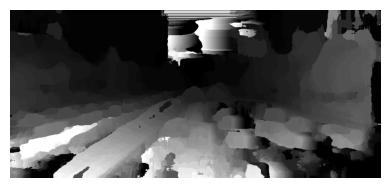

In [58]:
matching_function = ssd
smooth_function = None

_, _, disparity_ssd = Match(img_gt=image_ground_truth, img_left=image_left, img_right=image_right, \
      matching_function=matching_function, size=size, max_disparity=max_disparity, \
      smooth_function=smooth_function, _print=_print)

Runtime:  2.73s
- errors less than 0.25px:  0.0961553732884094 
- errors less than 0.5px:  0.18484611283168273 
- errors less than 1px:  0.3333787110460697 
- errors less than 2px:  0.5005728936232969 
- errors less than 4px:  0.6635015712033036
- root mean squared: 14.14846284511473


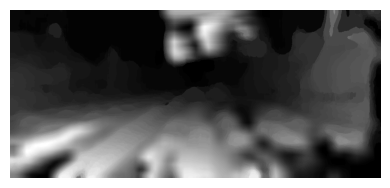

In [59]:
matching_function = ssd
smooth_function = ssd_smooth

_, _, disparity_ssd_smooth = Match(img_gt=image_ground_truth, img_left=image_left, img_right=image_right, \
      matching_function=matching_function, size=size, max_disparity=max_disparity, \
      smooth_function=smooth_function, _print=_print)

#### ZSSD (unsmoothed & smoothed)

Runtime:  1.55s
- errors less than 0.25px:  0.07346651692021464 
- errors less than 0.5px:  0.1432801279651499 
- errors less than 1px:  0.26876084810945106 
- errors less than 2px:  0.42077618577635595 
- errors less than 4px:  0.5970912886135974
- root mean squared: 19.772774270871718


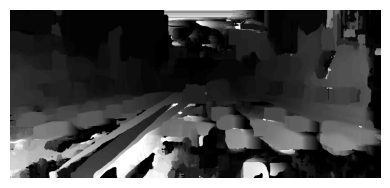

In [60]:
matching_function = zssd
smooth_function = None

_, _, disparity_zssd = Match(img_gt=image_ground_truth, img_left=image_left, img_right=image_right, \
      matching_function=matching_function, size=size, max_disparity=max_disparity, \
      smooth_function=smooth_function, _print=_print)

Runtime:  3.41s
- errors less than 0.25px:  0.07421524918036507 
- errors less than 0.5px:  0.1451406141873419 
- errors less than 1px:  0.2728448422557261 
- errors less than 2px:  0.4260400004537771 
- errors less than 4px:  0.5961156677897651
- root mean squared: 17.85234529327789


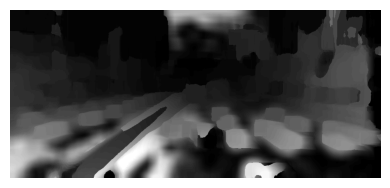

In [61]:
matching_function = zssd
smooth_function = zssd_smooth

_, _, disparity_ssd_smooth = Match(img_gt=image_ground_truth, img_left=image_left, img_right=image_right, \
      matching_function=matching_function, size=size, max_disparity=max_disparity, \
      smooth_function=smooth_function, _print=_print)

#### ZNCC (unsmoothed & smoothed)

Runtime:  2.82s
- errors less than 0.25px:  0.09981962359187285 
- errors less than 0.5px:  0.19591827473936177 
- errors less than 1px:  0.36091163824887407 
- errors less than 2px:  0.5749583092264234 
- errors less than 4px:  0.8320003630217019
- root mean squared: 7.017117462005527


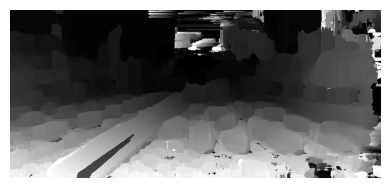

In [62]:
matching_function = zncc
smooth_function = None

_, _, disparity_zncc = Match(img_gt=image_ground_truth, img_left=image_left, img_right=image_right, \
      matching_function=matching_function, size=size, max_disparity=max_disparity, \
      smooth_function=smooth_function, _print=_print)

Runtime:  4.04s
- errors less than 0.25px:  0.09900282476261785 
- errors less than 0.5px:  0.19634936301035746 
- errors less than 1px:  0.3672758624601527 
- errors less than 2px:  0.5992240411122077 
- errors less than 4px:  0.8511724466528264
- root mean squared: 7.165589028698559


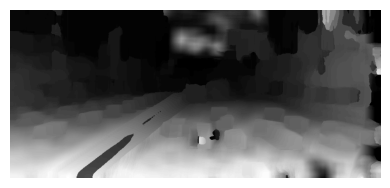

In [63]:
matching_function = zncc
smooth_function = zncc_smooth

_, _, disparity_zncc_smooth = Match(img_gt=image_ground_truth, img_left=image_left, img_right=image_right, \
      matching_function=matching_function, size=size, max_disparity=max_disparity, \
      smooth_function=smooth_function, _print=_print)

#### Conclusion on smoothing

The smoothing does improve the performance to a certain extent.

## Are all pixels in the matching window equally important?

Runtime:  1.82s
- errors less than 0.25px:  0.09981962359187285 
- errors less than 0.5px:  0.19591827473936177 
- errors less than 1px:  0.36091163824887407 
- errors less than 2px:  0.5749583092264234 
- errors less than 4px:  0.8320003630217019
- root mean squared: 7.017117462005527


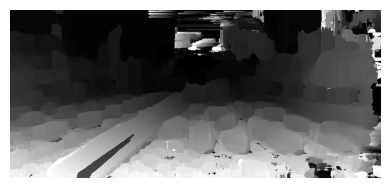

In [83]:
matching_function = zncc
smooth_function = None

_, _, disparity_zncc = Match(img_gt=image_ground_truth, img_left=image_left, img_right=image_right, \
      matching_function=matching_function, size=size, max_disparity=max_disparity, \
      smooth_function=smooth_function, _print=_print)

### Using Gaussian Filter with ZNCC

Runtime:  10.77s
- errors less than 0.25px:  0.06665986000975621 
- errors less than 0.5px:  0.13763060272946942 
- errors less than 1px:  0.2744330622014997 
- errors less than 2px:  0.4575094442364633 
- errors less than 4px:  0.6579995235340163
- root mean squared: 7.177059793529068


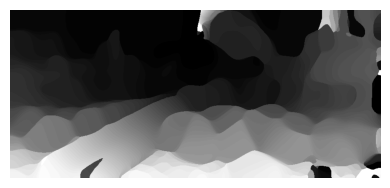

In [185]:
matching_function = zncc_gauss
smooth_function = None
size = 15

_, _, disparity_zncc_gauss = Match(img_gt=image_ground_truth, img_left=image_left, img_right=image_right, \
      matching_function=matching_function, size=size, max_disparity=max_disparity, \
      smooth_function=smooth_function, _print=_print)

## Tuning Window Size & Performance Check

In [129]:

'''
You can change the input images here by following the format:
    disparity_image_name - str
    imge_left_right_name - list of two str
    
e.g. disparity_image_name = '2018-07-09-16-11-56_2018-07-09-16-11-56-702-disparity.png'
     imge_left_right_name =  ['2018-07-09-16-11-56_2018-07-09-16-11-56-702-left.jpg'
                              '2018-07-09-16-11-56_2018-07-09-16-11-56-702-right.jpg']
'''

img_gt_name = disparity_imgs[0]
img_left_right_name = left_right_imgs[0]

image_left, image_right, image_ground_truth = read_image(img_gt_name, img_left_right_name)

# dynamic step size based on the max disparity
max_disparity = int(np.max(image_ground_truth)) + 2 

window_sizes = [5, 15, 25, 35, 45, 55, 65, 75, 85]

### SSD

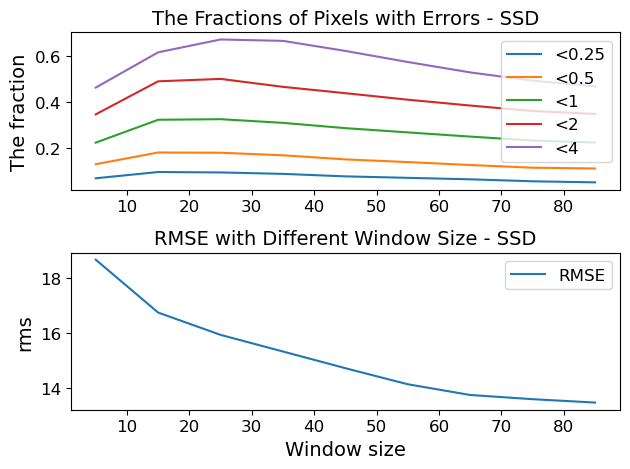

SSD done!


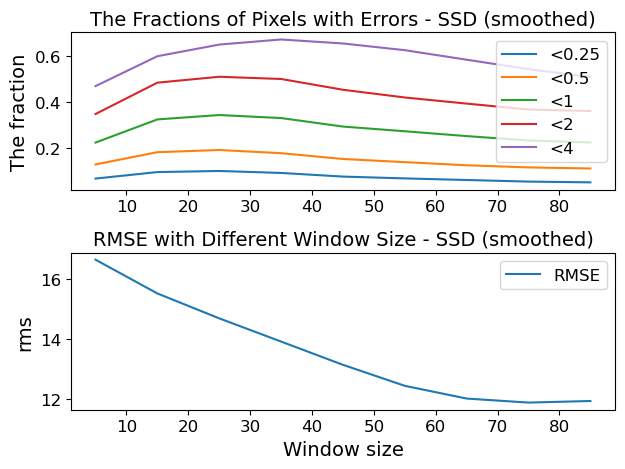

SSD (smoothed) done!


In [164]:
error_records = []
smooth_error_records = []
for size in window_sizes:
    dismap = ssd(image_left, image_right, max_disparity, size)
    with HiddenPrints():
        error_025, error_05, error_1, error_2, error_4, rms = evaluate(dismap, image_ground_truth)
    error_records.append([error_025, error_05, error_1, error_2, error_4, rms])
    # smooth
    dismap_smooth = ssd_smooth(image_left, image_right, dismap, 0.5, max_disparity, size)
    with HiddenPrints():
        smooth_error_025, smooth_error_05, smooth_error_1, smooth_error_2, smooth_error_4, smooth_rms = evaluate(dismap_smooth, image_ground_truth)
    smooth_error_records.append([smooth_error_025, smooth_error_05, smooth_error_1, smooth_error_2, smooth_error_4, smooth_rms])

plot_record("SSD", window_sizes, error_records)
plot_record("SSD (smoothed)", window_sizes, smooth_error_records)

### ZSSD

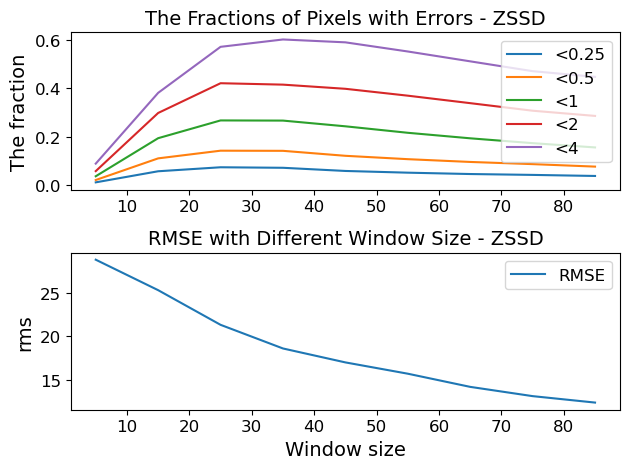

ZSSD done!


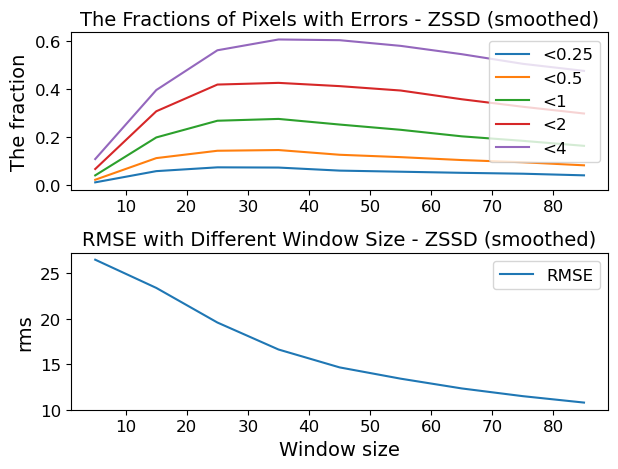

ZSSD (smoothed) done!


In [165]:
error_records = []
smooth_error_records = []
for size in window_sizes:
    dismap = zssd(image_left, image_right, max_disparity, size)
    with HiddenPrints():
        error_025, error_05, error_1, error_2, error_4, rms = evaluate(dismap, image_ground_truth)
    error_records.append([error_025, error_05, error_1, error_2, error_4, rms])
    # smooth
    dismap_smooth = zssd_smooth(image_left, image_right, dismap, 0.5, max_disparity, size)
    with HiddenPrints():
        smooth_error_025, smooth_error_05, smooth_error_1, smooth_error_2, smooth_error_4, smooth_rms = evaluate(dismap_smooth, image_ground_truth)
    smooth_error_records.append([smooth_error_025, smooth_error_05, smooth_error_1, smooth_error_2, smooth_error_4, smooth_rms])

plot_record("ZSSD", window_sizes, error_records)
plot_record("ZSSD (smoothed)", window_sizes, smooth_error_records)

### ZNCC

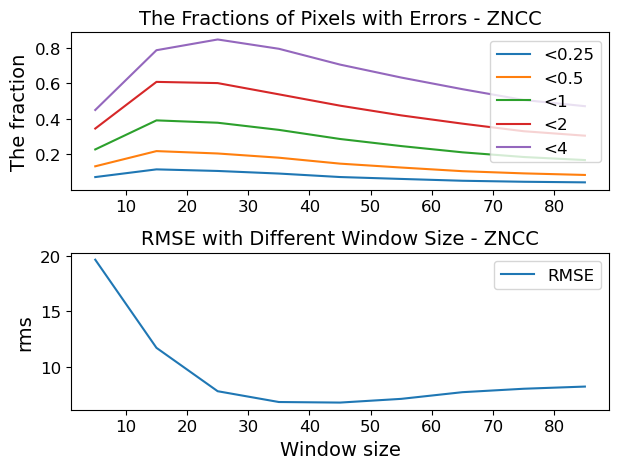

ZNCC done!


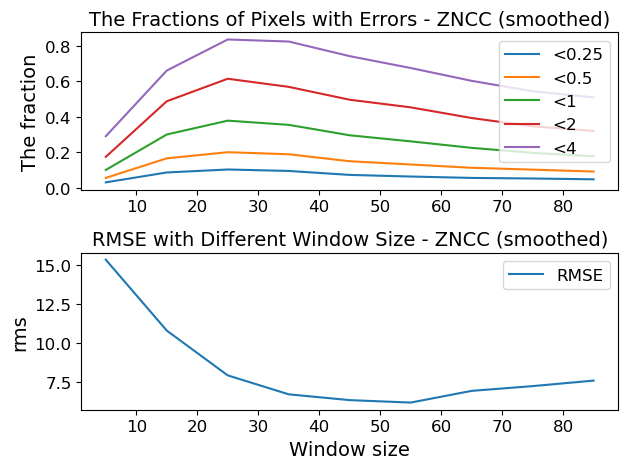

ZNCC (smoothed) done!


In [130]:
error_records = []
smooth_error_records = []
for size in window_sizes:
    dismap = zncc(image_left, image_right, max_disparity, size)
    with HiddenPrints():
        error_025, error_05, error_1, error_2, error_4, rms = evaluate(dismap, image_ground_truth)
    error_records.append([error_025, error_05, error_1, error_2, error_4, rms])
    # smooth
    dismap_smooth = zncc_smooth(image_left, image_right, dismap, 0.5, max_disparity, size)
    with HiddenPrints():
        smooth_error_025, smooth_error_05, smooth_error_1, smooth_error_2, smooth_error_4, smooth_rms = evaluate(dismap_smooth, image_ground_truth)
    smooth_error_records.append([smooth_error_025, smooth_error_05, smooth_error_1, smooth_error_2, smooth_error_4, smooth_rms])

plot_record("ZNCC", window_sizes, error_records)
plot_record("ZNCC (smoothed)", window_sizes, smooth_error_records)

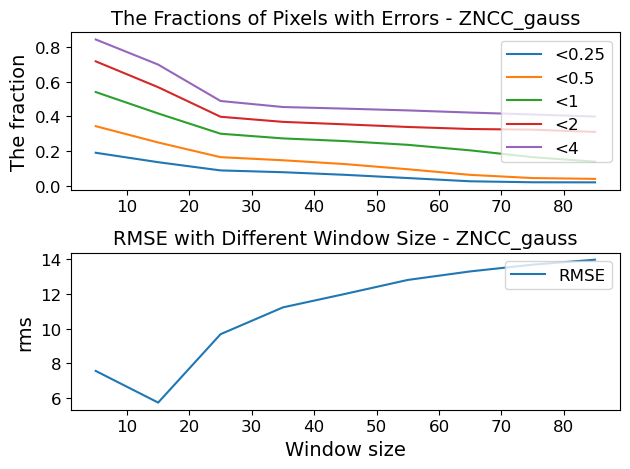

ZNCC_gauss done!


In [182]:
error_records_gauss = []
for size in window_sizes:
    dismap = zncc_gauss(image_left, image_right, max_disparity, size)
    with HiddenPrints():
        error_025, error_05, error_1, error_2, error_4, rms = evaluate(dismap, image_ground_truth)
    error_records_gauss.append([error_025, error_05, error_1, error_2, error_4, rms])
    
plot_record("ZNCC_gauss", window_sizes, error_records_gauss)


## Smoothing Effect on RMSE

(array([ 4.,  6.,  8., 10., 12., 14., 16., 18., 20., 22.]),
 <a list of 10 Text major ticklabel objects>)

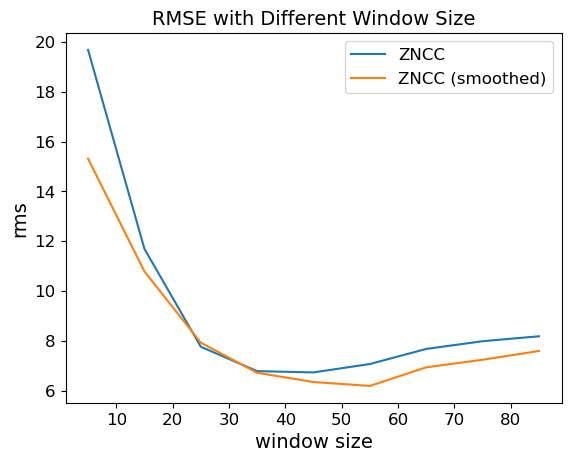

In [167]:
plt.plot(window_sizes, np.array(error_records)[:,-1], label='ZNCC')
plt.plot(window_sizes, np.array(smooth_error_records)[:,-1], label='ZNCC (smoothed)')
plt.legend(loc=1, fontsize=12)
plt.xlabel('Window size', fontsize=14)
plt.ylabel('RMSE', fontsize=14)
plt.title('RMSE with Different Window Size', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

(array([ 4.,  6.,  8., 10., 12., 14., 16., 18., 20., 22.]),
 <a list of 10 Text major ticklabel objects>)

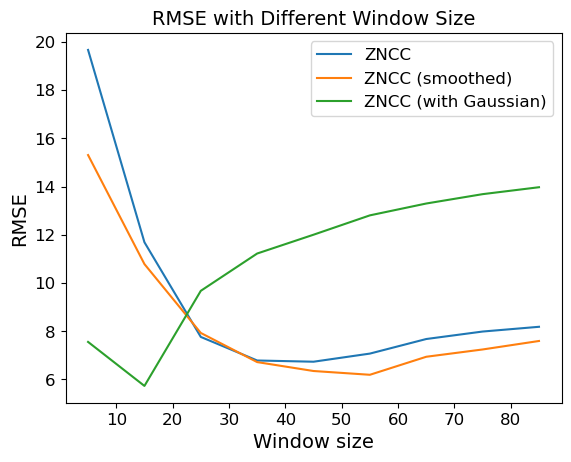

In [188]:
plt.plot(window_sizes, np.array(error_records)[:,-1], label='ZNCC')
plt.plot(window_sizes, np.array(smooth_error_records)[:,-1], label='ZNCC (smoothed)')
plt.plot(window_sizes, np.array(error_records_gauss)[:,-1], label='ZNCC (with Gaussian)')
plt.legend(loc=1, fontsize=12)
plt.xlabel('Window size', fontsize=14)
plt.ylabel('RMSE', fontsize=14)
plt.title('RMSE with Different Window Size', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

In [138]:
# RMSE average decrease percentage
np.mean((np.array(error_records)[:,-1] - np.array(smooth_error_records)[:,-1]) 
        / np.array(smooth_error_records)[:,-1]) 

0.09408218949050068

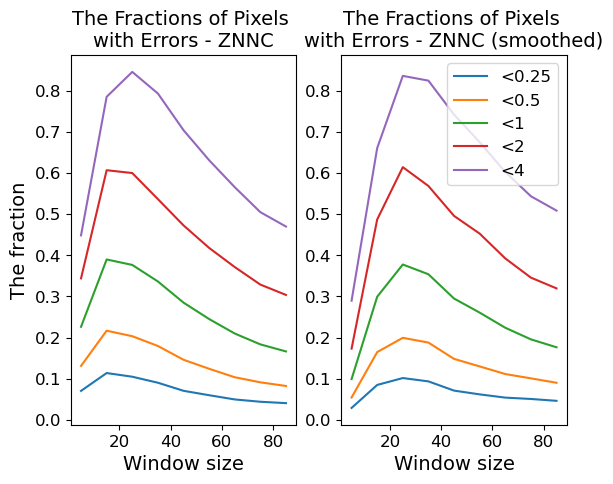

In [154]:

ax1 = plt.subplot(1, 2, 1)
plt.plot(window_sizes, [error_records[i][0] for i in range(len(window_sizes))], label='<0.25')
plt.plot(window_sizes, [error_records[i][1] for i in range(len(window_sizes))], label='<0.5')
plt.plot(window_sizes, [error_records[i][2] for i in range(len(window_sizes))], label='<1')
plt.plot(window_sizes, [error_records[i][3] for i in range(len(window_sizes))], label='<2')
plt.plot(window_sizes, [error_records[i][4] for i in range(len(window_sizes))], label='<4')
plt.xlabel('Window size', fontsize=14)
plt.ylabel('The fraction', fontsize=14)
plt.title('The Fractions of Pixels \nwith Errors - ' + 'ZNNC', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

ax2 = plt.subplot(1, 2, 2, sharey=ax1)
plt.plot(window_sizes, [smooth_error_records[i][0] for i in range(len(window_sizes))], label='<0.25')
plt.plot(window_sizes, [smooth_error_records[i][1] for i in range(len(window_sizes))], label='<0.5')
plt.plot(window_sizes, [smooth_error_records[i][2] for i in range(len(window_sizes))], label='<1')
plt.plot(window_sizes, [smooth_error_records[i][3] for i in range(len(window_sizes))], label='<2')
plt.plot(window_sizes, [smooth_error_records[i][4] for i in range(len(window_sizes))], label='<4')
plt.legend(loc=1, fontsize=12)
plt.title('The Fractions of Pixels \nwith Errors - ' + 'ZNNC (smoothed)', fontsize=14)
plt.xlabel('Window size', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.show()


## Sub-pixel Technique (Attempted)

In [118]:
def zncc_subpixel(im_l, im_r, steps, window_size):
    height, width = im_l.shape
    
    mean_l = np.zeros((height, width))
    mean_r = np.zeros((height, width))
    
    s = np.zeros((height, width))
    s_l = np.zeros((height, width))
    s_r = np.zeros((height, width))
    
    dmaps = np.zeros((height, width,steps))
    
    # calculate the mean of the image block
    uniform_filter(im_l,window_size,mean_l)
    uniform_filter(im_r,window_size,mean_r)
    
    # try different disparity
    for displ in range(steps):
        # make the left image move
        move_l = np.roll(im_l, - displ, axis=1)

        uniform_filter(move_l * im_r, window_size, s)
        uniform_filter(move_l * move_l, window_size, s_l)
        uniform_filter(im_r * im_r,window_size,s_r)
        dmaps[:,:,displ] = s / np.sqrt(s_l * s_r)
        
    # Symmetric Sub-pixel
    dmaps = np.concatenate((dmaps, np.zeros((height, width,1))), axis=2)
    dmaps = np.concatenate((np.zeros((height, width,1)), dmaps), axis=2)
    dmaps = dmaps[:,:,1:-1]
    dmaps = (dmaps[:,:,2:] - dmaps[:,:,:-2]) / (2 * dmaps[:,:,1:-1] - dmaps[:,:,2:] - dmaps[:,:,:-2])
    
    return np.argmax(dmaps, axis=2)

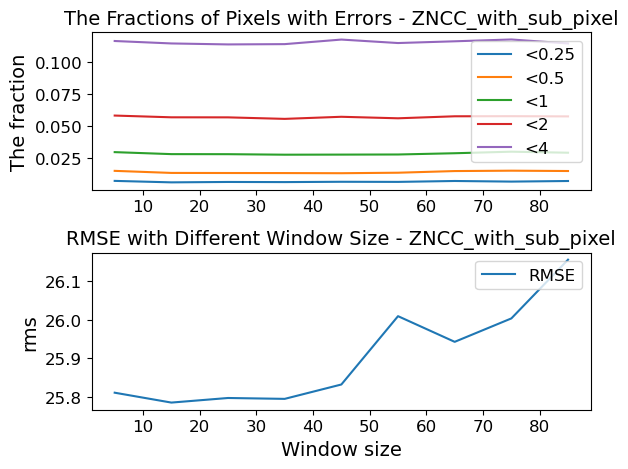

ZNCC_with_sub_pixel done!


In [122]:
error_records = []
smooth_error_records = []
for size in window_sizes:
    dismap = zncc_subpixel(image_left, image_right, max_disparity, size)
    with HiddenPrints():
        error_025, error_05, error_1, error_2, error_4, rms = evaluate(dismap, image_ground_truth)
    error_records.append([error_025, error_05, error_1, error_2, error_4, rms])

plot_record("ZNCC_with_sub_pixel", window_sizes, error_records)

## Average Performance of Final Algorithms

### Check Smoothed ZNCC

In [175]:
size = 30 # window size
matching_function = zncc # using any previous defined matching function (without smoothing)
smooth_function = zncc_smooth # using corresponding smoothed function, if you want to
_print = False # if you don't want to print any output, set it to False

errors_sum_zncc_smooth = np.array([0.,0.,0.,0.,0.])
rms_sum_zncc_smooth = 0

for i in range(14):
    img_gt_name = disparity_imgs[i]
    img_left_right_name = left_right_imgs[i]

    image_left, image_right, image_ground_truth = read_image(img_gt_name, img_left_right_name)

    # dynamic step size based on the max disparity
    max_disparity = int(np.max(image_ground_truth)) + 2
    
    errors, rms, _ = Match(img_gt=image_ground_truth, img_left=image_left, img_right=image_right, \
          matching_function=matching_function, size=size, max_disparity=max_disparity, \
          smooth_function=smooth_function, _print=_print)
    
    errors_sum_zncc_smooth += np.array(list(errors))
    rms_sum_zncc_smooth += rms

errors_average_smooth = errors_sum_zncc_smooth / 15
rms_average_smooth = rms_sum_zncc_smooth / 15

print("Average Performance of Smoothed ZNCC on All 15 Set of Images")
print("- RMSE: ", rms_average_smooth)
print("- Fraction of pixels in small-error ranges:")
print("     errors less than 0.25px: ", errors_average_smooth[0],
      "\n     errors less than 0.5px: ", errors_average_smooth[1],
      "\n     errors less than 1px: ", errors_average_smooth[2],
      "\n     errors less than 2px: ", errors_average_smooth[3],
      "\n     errors less than 4px: ", errors_average_smooth[4])

Average Performance on All 15 Set of Images
- RMSE:  7.739017212962865
- Fraction of pixels in small-error ranges:
     errors less than 0.25px:  0.09284946761331098 
     errors less than 0.5px:  0.17949850618555654 
     errors less than 1px:  0.3232009994636263 
     errors less than 2px:  0.5151842673368185 
     errors less than 4px:  0.7217412466098809


### Check ZNCC with Gaussian

In [180]:
size = 15 # window size
matching_function = zncc_gauss # using any previous defined matching function (without smoothing)
smooth_function = None # using corresponding smoothed function, if you want to
_print = False # if you don't want to print any output, set it to False

errors_sum_zncc_guass = np.array([0.,0.,0.,0.,0.])
rms_sum_zncc_gauss = 0

for i in range(14):
    img_gt_name = disparity_imgs[i]
    img_left_right_name = left_right_imgs[i]

    image_left, image_right, image_ground_truth = read_image(img_gt_name, img_left_right_name)

    # dynamic step size based on the max disparity
    max_disparity = int(np.max(image_ground_truth)) + 2
    
    errors, rms, _ = Match(img_gt=image_ground_truth, img_left=image_left, img_right=image_right, \
          matching_function=matching_function, size=size, max_disparity=max_disparity, \
          smooth_function=smooth_function, _print=_print)
    
    errors_sum_zncc_guass += np.array(list(errors))
    rms_sum_zncc_gauss += rms

errors_average_zncc_gauss = errors_sum_zncc_guass / 15
rms_average_zncc_gauss = rms_sum_zncc_gauss / 15

print("Average Performance of ZNCC with Gaussian Filter on All 15 Set of Images")
print("- RMSE: ", rms_average_zncc_gauss)
print("- Fraction of pixels in small-error ranges:")
print("     errors less than 0.25px: ", errors_average_zncc_gauss[0],
      "\n     errors less than 0.5px: ", errors_average_zncc_gauss[1],
      "\n     errors less than 1px: ", errors_average_zncc_gauss[2],
      "\n     errors less than 2px: ", errors_average_zncc_gauss[3],
      "\n     errors less than 4px: ", errors_average_zncc_gauss[4])

Average Performance of ZNCC with Gaussian Filter on All 15 Set of Images
- RMSE:  7.253573234670541
- Fraction of pixels in small-error ranges:
     errors less than 0.25px:  0.08157579934613028 
     errors less than 0.5px:  0.15918654664722137 
     errors less than 1px:  0.28605288227564163 
     errors less than 2px:  0.4473208580633484 
     errors less than 4px:  0.6167945636727439
